In [ ]:
!pip install shap eli5

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Data description

The dataset was made as part as the Big Data Infastructure and Technologies course in ITMO University.

**Aim:** to develop ML models to estimate GDPs of 34 European countries using meteorological and agricultural data.

**Predictors:**:

- 2 m air temperature (t2m; ERA5 on single level);
- total precipitations (tp; ERA5 on single level);
- agricultural land area (agr; The World Bank);
- cereal yield (yld; The World Bank).

**Target:**

- gross domestic product (gdp; The World Bank).


# Modeling stage

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import math
from scipy.stats import norm, truncnorm
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_error as MSE

modeling_data = pd.read_csv('/content/drive/My Drive/MLT/modeling_data.csv', header=0)
modeling_data = modeling_data.drop(['Cluster 1', 'Cluster 2', 'Cluster 3'], axis = 1)
modeling_data

,t2m,tp,yld,agr,gdp
0,12.453266,0.000130,3175.1,24.515412,3.480355e+09
1,7.256879,0.000160,5403.9,1.647300,1.972896e+11
2,7.906725,0.000100,1949.7,12.096827,1.273686e+10
3,10.603078,0.000130,8021.4,1.176005,2.367925e+11
4,11.002707,0.000130,2550.2,9.001464,5.567406e+09
...,...,...,...,...,...
695,14.490549,0.000073,3445.5,2.468943,1.394320e+12
696,3.693643,0.000097,6292.1,1.392125,5.338795e+11
697,6.462529,0.000196,6580.8,0.647746,7.213691e+11
698,10.671448,0.000062,4975.8,8.965181,1.538830e+11


In [5]:
X_train, X_test, y_train, y_test = train_test_split(modeling_data.loc[:, ~modeling_data.columns.isin(['gdp'])],
                                                    modeling_data.loc[:, [ 'gdp']], test_size = 0.25,
                                                    random_state = 21, shuffle = True)

In [10]:
n = 350
rf = RandomForestRegressor(n_estimators = n, criterion = 'squared_error', max_depth = None, min_samples_split=2,
                            n_jobs = -1,
                           random_state = 1)
rf.fit(X_train, y_train)

<ipython-input-10-d3ae375e4029>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RandomForestRegressor(n_estimators=350, n_jobs=-1, random_state=1)

In [11]:
predictions = rf.predict(X_test)
preds = pd.DataFrame({ "gdp":predictions})
test_score = r2_score(y_test, preds)
train_score = r2_score(y_train, rf.predict(X_train))
print('--------------------\n','Test score', np.round(test_score,3), '\n',
      'Train score:', np.round(train_score,3), '\n','--------------------\n')

--------------------
 Test score 0.797 
 Train score: 0.948 
 --------------------



# Feature Importance Analysis

- First of all lets use *TreeExplainer* function by SHAP to look into how features affect the output. It can be seen right away that yld (cereal yield) is the most and tp (total precipitation) is the least important predictor.

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


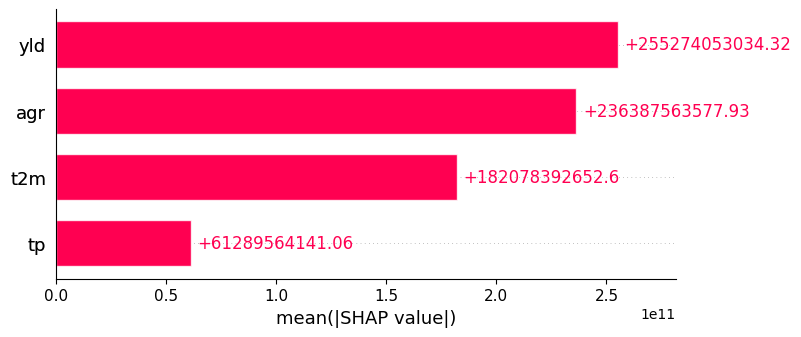

In [14]:
import shap

explainer = shap.TreeExplainer(rf)
sh = explainer(X_train)
shap.plots.bar(sh)

- Furthemore, we can use *beeswarm* function to see how different ranges of feature values affect the output. It is clear from the plot that low values of yld and t2m provide low values of GDP. And in opposite, higher precipitations and temperature mean high GDP.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


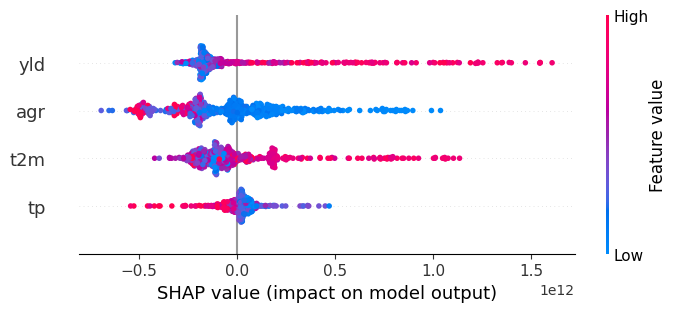

In [15]:
shap.plots.beeswarm(sh)

- The third type of plot we can use to interpretate the modeling results is PDPs (partial dependence plot). This type of plot how changes of one feature correlate with changes of another one's and how they affect the output together.

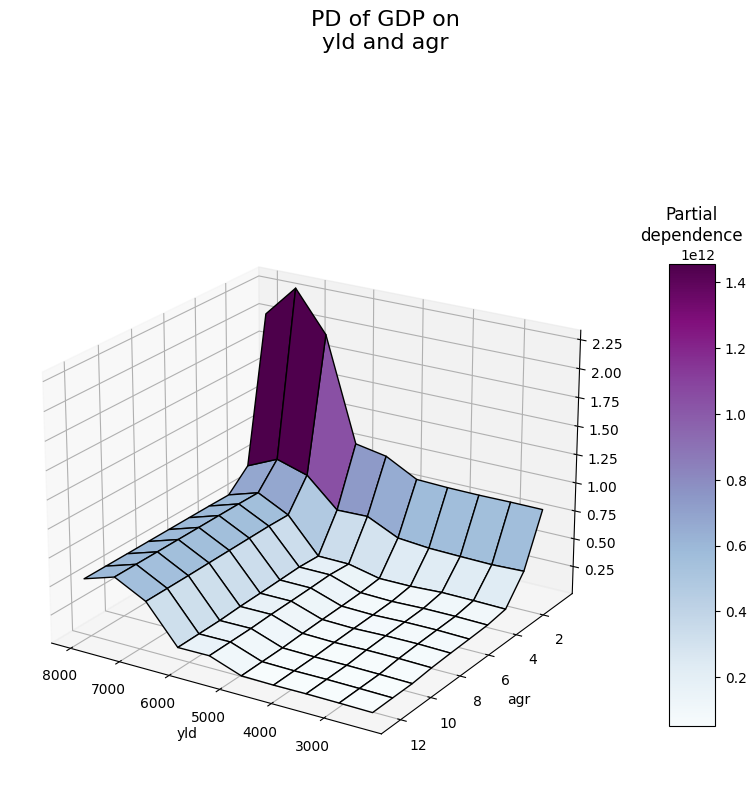

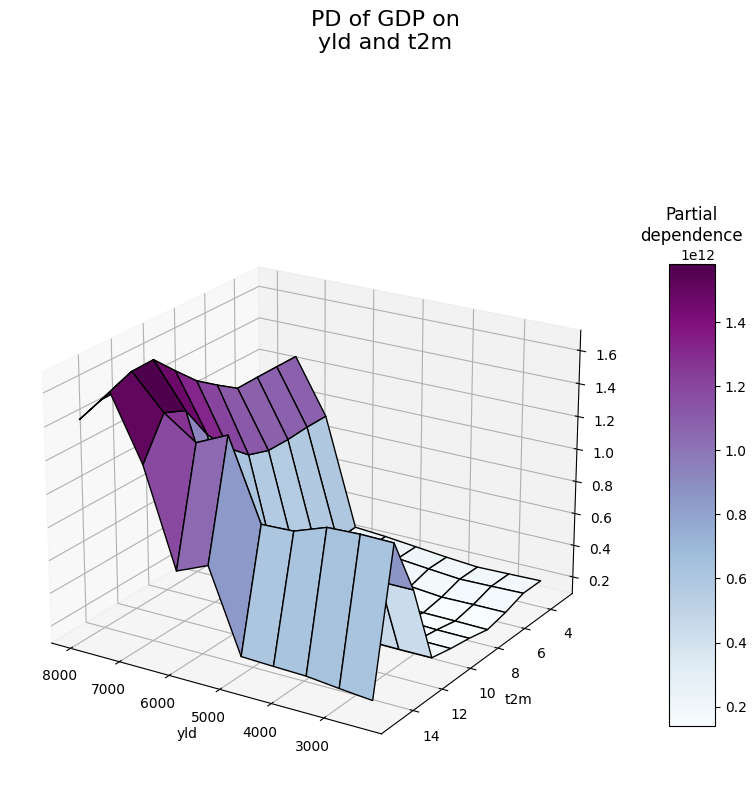

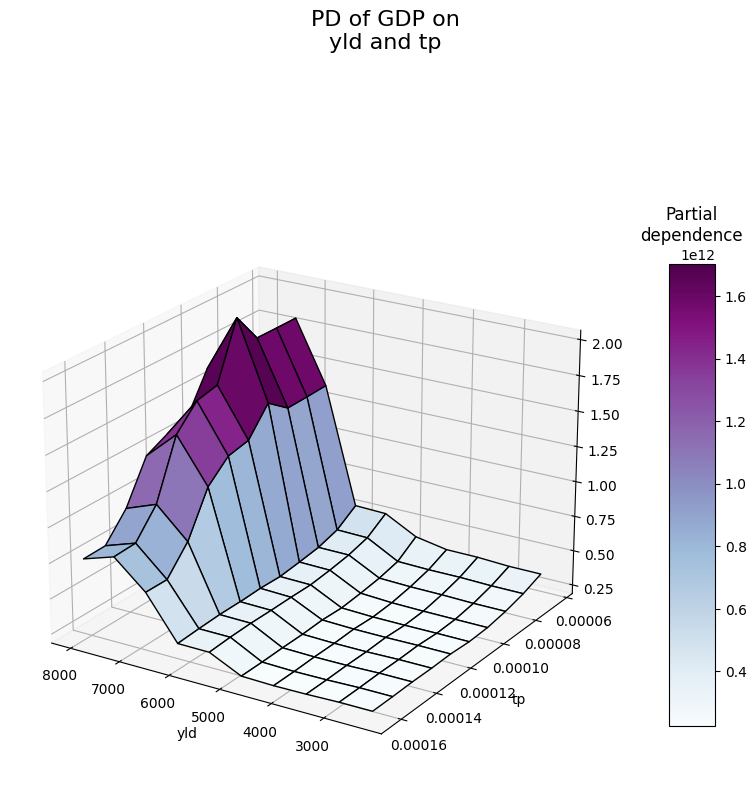

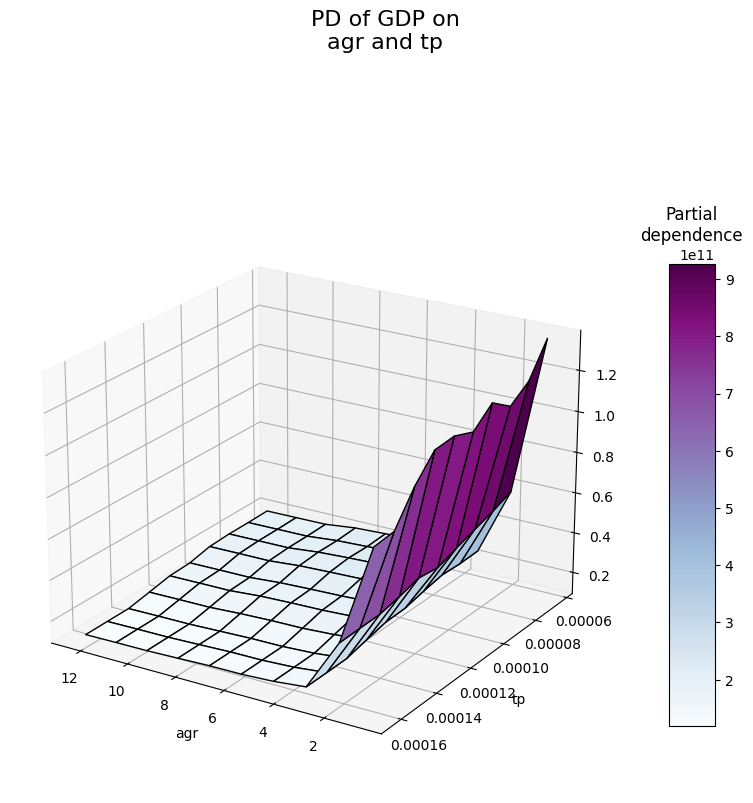

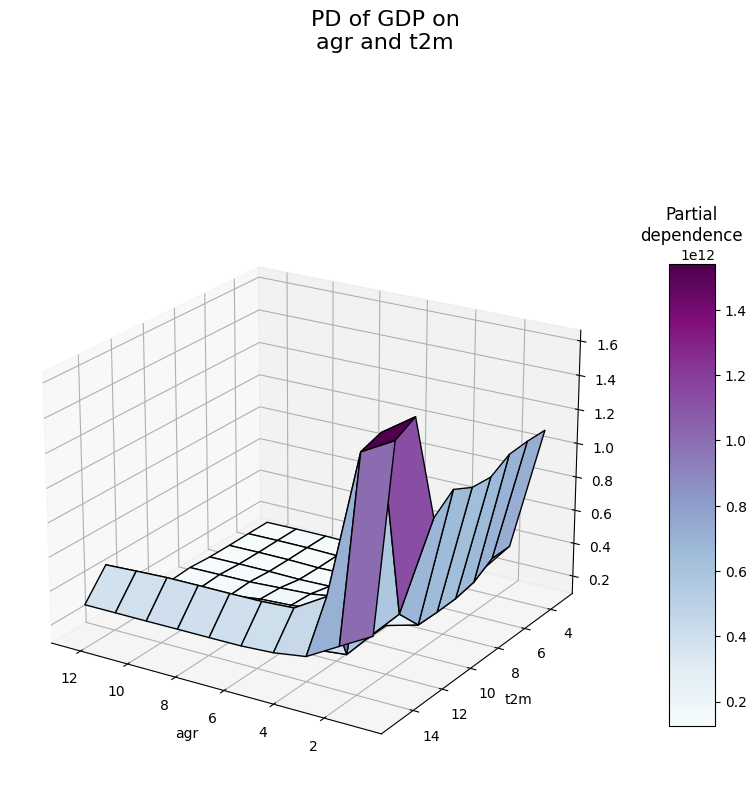

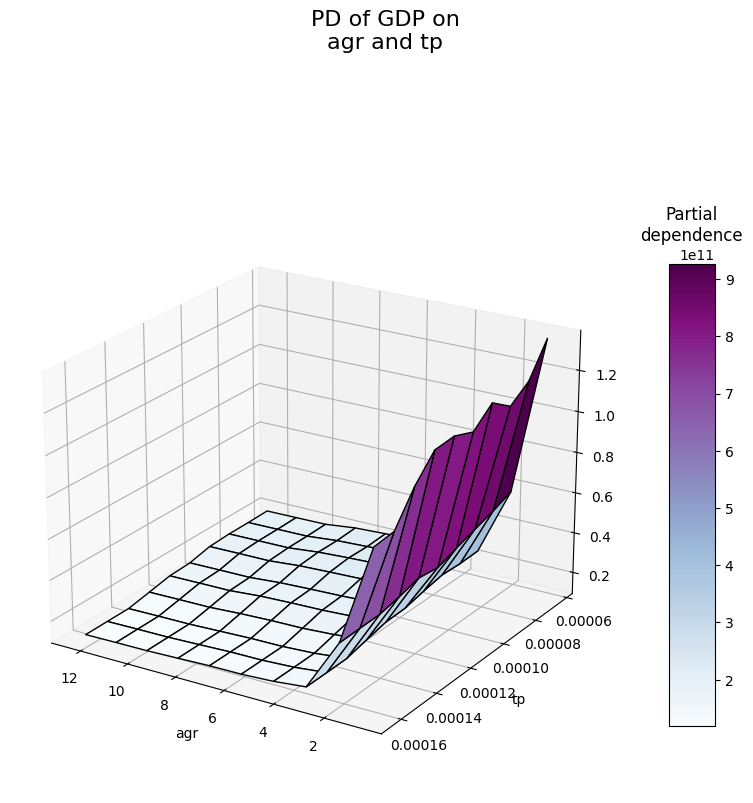

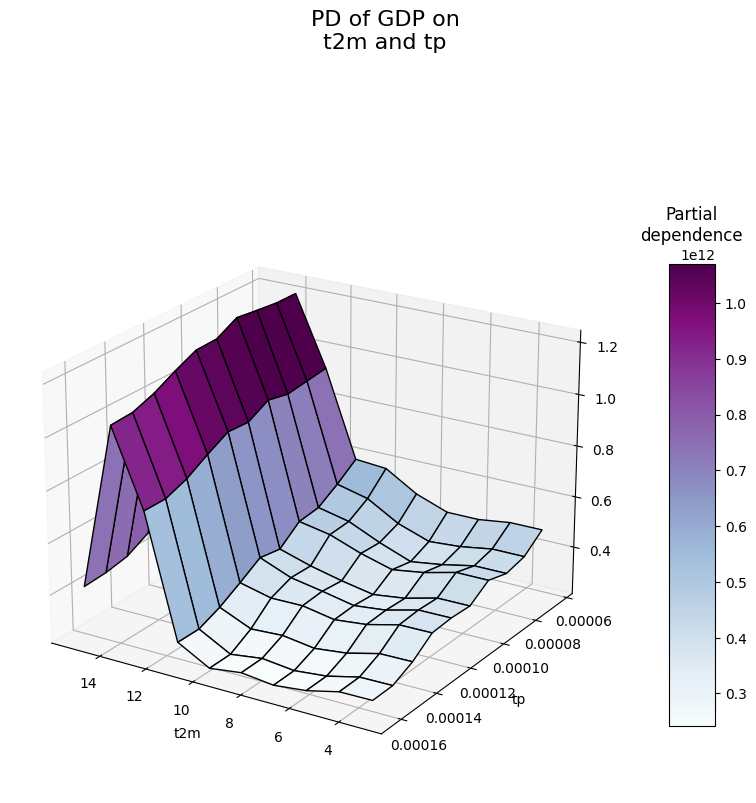

In [20]:
import mpl_toolkits.mplot3d
from sklearn.inspection import partial_dependence
import matplotlib.pyplot as plt

F = [['yld', 'agr'], ['yld', 't2m'], ['yld', 'tp'], ['agr','tp'], ['agr', 't2m'], ['agr', 'tp'], ['t2m', 'tp']]

for features in F:
  fig = plt.figure(figsize=(10, 10))
  pdp = partial_dependence(
      rf, X_train, features=features, kind="average", grid_resolution=10
  )
  XX, YY = np.meshgrid(pdp["values"][0], pdp["values"][1])
  Z = pdp.average[0].T
  ax = fig.add_subplot(projection="3d")
  fig.add_axes(ax)

  surf = ax.plot_surface(XX, YY, Z, rstride=1, cstride=1, cmap=plt.cm.BuPu, edgecolor="k")
  ax.set_xlabel(features[0])
  ax.set_ylabel(features[1])
  fig.suptitle(
      f"PD of GDP on\n{features[0]} and {features[1]}",
      fontsize=16,
  )
  # pretty init view
  ax.view_init(elev=22, azim=122)
  clb = plt.colorbar(surf, pad=0.08, shrink=0.6, aspect=10)
  clb.ax.set_title("Partial\ndependence")
  plt.show()

- Finally, by randomly shuffling the values of features we can analyze the changes in the target (permutation importance). It can be seen that the most important feature here is *agr*, however its error has uncertainty of ±0.17, which is the biggest amont all the features. Reversely, we can say that *tp* is the least important feature with the lowest uncertainty.

In [23]:
from eli5.sklearn import PermutationImportance
import eli5
perm = PermutationImportance(rf).fit(X_test, y_test)
eli5.show_weights(perm,feature_names=X_train.columns.tolist())

Weight,Feature
0.7169 ± 0.1716,agr
0.5165 ± 0.0655,yld
0.3449 ± 0.1226,t2m
0.0515 ± 0.0206,tp


# Conclusion
It is clear from the plots that despite cereal yield and agricultural land area are the most important features, all four predictors are important for predicting countries' average annual GDPs.